# README

This takes the data generated from gen_2DWindow_data.py and converts it into graphs. This experiment is taking 12 curves where there are windows around the null points. These windows around the null points are varied to show how close we need to be to the null point to have improved MSE beyond the conventional method. This code is changed from the npWindow experiment in that both windows vary in the central location. We also allow the SNR to vary.

# Libraries

In [14]:
#Preparing all libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy
# import addcopyfighandler
import statistics
import math
import time
from tqdm import trange
from matplotlib import cm
import colorsys
from datetime import date
import pickle
import functools
import os
from matplotlib.ticker import MultipleLocator

# Initialization

### Window Analysis

In [15]:


cwd_temp = os.getcwd()
base_file = 'Stabilization'
cwd_full = cwd_temp.split(base_file, 1)[0]
print(cwd_full)

exp_file = 'Reassign_DATA'
exp_date = '12Dec23'

SNR_input = 100
add_tag = "illT2"
method = "AIC"

param_oi = 3

assert(param_oi >= 0 and param_oi < 6)

ParamTitle_6p = [r'$T_{11}$', r'$T_{12}$', r'$c_1$', r'$c_2$', r'$T_{21}$', r'$T_{22}$']

/home/hamptong2/


In [16]:
with open(f'{cwd_full}{base_file}/Reassign_Experiment/{exp_file}/hprParameter_{method}_{add_tag}_SNR_{SNR_input}_{exp_date}.pkl', 'rb') as handle:
    
    dict = pickle.load(handle)
    np1_array = dict['np1_array']
    np2_array = dict['np2_array']
    SNR_value = dict["SNR_value"]
    true_params = dict["true_params"]
    nTE = dict["nTE"]
    dTE = dict["dTE"]
    var_reps = dict["var_reps"]
    multi_start = dict['multi_start']
    handle.close()

T11, T12, c1, c2, T21, T22 = true_params

R0_coeff_TI1 = (c1**2 * T21 *(T21 - T22)**4)/(2*T11**2 * (T21 + T22)**4)
R0_coeff_TI2 = (c2**2 * T22 *(T21 - T22)**4)/(2*T12**2 * (T21 + T22)**4)

TI1star = np.log(2)*T11
TI2star = np.log(2)*T12

### Standard Analysis

In [17]:
SR_folder = 'Comparison_DATA'
SR_date = '06Dec23'

In [18]:
with open(f'{cwd_full}{base_file}/Standard_Comparisons/{SR_folder}/hprParameter_AIC_SNRsuite_illT2_{SR_date}.pkl', 'rb') as handle:
    
    dict = pickle.load(handle)
    SR_SNR_values = dict["SNR_values"]
    SR_true_params = dict["true_params"]
    SR_TI_STANDARD = dict["TI_DATA"]
    SR_nTE = dict["nTE"]
    SR_dTE = dict["dTE"]
    SR_var_reps = dict["var_reps"]
    SR_AIC_eval_iter = dict['AIC_eval_iter']
    SR_multi_start = dict['multi_start']
    handle.close()


for iter in range(len(true_params)):
    assert(SR_true_params[iter] == true_params[iter])

assert(np.any(SNR_input == SR_SNR_values))

# Functions

In [19]:
def to_readable_2DWindow(file):
    df = pd.read_pickle(file)
    ALL_CENTER1 = np.stack(df["NP1"].values) #shape: (len(center_diff_range))
    ALL_CENTER2 = np.stack(df["NP2"].values) #shape: (len(center_diff_range))
    ALL_TI = np.stack(df["TI_DATA"].values) #shape: (len(center_diff_range), len(TI))
    ALL_SNR_eTime = np.stack(df["SNR_eTime"].values) #shape: len(center_diff_range))
    ALL_MSE = np.stack(df["MSE"].values) #shape: (len(center_diff_range))
    ALL_VAR = np.stack(df["var"].values) #shape: (len(center_diff_range))

    ALL_BIAS = np.stack(df["bias"].values) #shape: (len(center_diff_range))

    ALL_pEst_AIC = np.stack(df["pEst_AIC"].values) #shape: (len(center_diff_range), num_iters, num_params)
    ALL_pEst_cf = np.stack(df["pEst_cf"].values) #shape: (len(center_diff_range), num_iters, num_params)
    
    return ALL_CENTER1, ALL_CENTER2, ALL_TI, ALL_SNR_eTime, ALL_MSE, ALL_VAR, ALL_BIAS, ALL_pEst_AIC, ALL_pEst_cf

def to_readable_SR(file):
    df = pd.read_pickle(file)
    ALL_SNR = np.stack(df["SNR"].values) #shape: len(center_diff_range))
    ALL_MSE = np.stack(df["MSE"].values) #shape: (len(center_diff_range))
    ALL_VAR = np.stack(df["var"].values) #shape: (len(center_diff_range))

    ALL_BIAS = np.stack(df["bias"].values) #shape: (len(center_diff_range))
    ALL_AIC = np.stack(df["AIC"].values) #shape: (len(center_diff_range))

    ALL_pEst_AIC = np.stack(df["pEst_AIC"].values) #shape: (len(center_diff_range), num_iters, num_params)
    ALL_pEst_cf = np.stack(df["pEst_cf"].values) #shape: (len(center_diff_range), num_iters, num_params)
    
    return ALL_SNR, ALL_MSE, ALL_VAR, ALL_BIAS, ALL_AIC, ALL_pEst_AIC, ALL_pEst_cf


def int_lengh_AIC(R0, diff_TE, SNR):
    return (2*diff_TE/(R0*SNR**2))**(1/2)

def calc_MSE(paramStore, true_params, clipped = False):
    varMat = np.var(paramStore, axis=0)
    biMat = np.mean(paramStore, axis = 0) - true_params  #E[p_hat] - p_true
    MSEMat = varMat + biMat**2
    if clipped:
        return MSEMat[-4:], biMat[-4:], varMat[-4:]
    return MSEMat, varMat, biMat

In [20]:
def prepare_data(p_oi):

    MSE_ordered = np.zeros((len(np1_array), len(np2_array), 3)) # ordering = ["ESPRESSO", "Conventional", "Curve Fit"]
    var_ordered = np.zeros((len(np1_array), len(np2_array), 3))
    bias_ordered = np.zeros((len(np1_array), len(np2_array), 3))

    eqSNR_ordered = np.zeros((len(np1_array), len(np2_array)))
    TI_ordered = np.zeros((len(np1_array), len(np2_array), 12))

    pEst_AIC_ordered = np.zeros((len(np1_array), len(np2_array), var_reps, len(ParamTitle_6p)))
    pEst_cf_ordered = np.zeros((len(np1_array), len(np2_array), var_reps, len(ParamTitle_6p)))

    data_name = f"{cwd_full}{base_file}/Reassign_Experiment/{exp_file}/reassignExp_{method}_{add_tag}_SNR_{SNR_input}_{exp_date}.pkl"

    print("Retrieving data for " + data_name)
    NP1, NP2, TI_DATA, eqSNR, MSE, VAR, BIAS, pEst_AIC, pEst_cf = to_readable_2DWindow(data_name)

    for index in range(len(MSE)):

        temp_np1 = NP1[index]
        temp_np2 = NP2[index]


        np1_index = np.where(temp_np1==np1_array)[0][0]
        np2_index = np.where(temp_np2==np2_array)[0][0]

        MSE_ordered[np1_index, np2_index,:] = MSE[index,:,p_oi]
        var_ordered[np1_index, np2_index,:] = VAR[index,:,p_oi]
        bias_ordered[np1_index, np2_index,:] = BIAS[index,:,p_oi]
        eqSNR_ordered[np1_index, np2_index] = eqSNR[index]
        TI_ordered[np1_index, np2_index,:] = TI_DATA[index,:]
        pEst_AIC_ordered[np1_index, np2_index,:,:] = pEst_AIC[index,:,:]
        pEst_cf_ordered[np1_index, np2_index,:,:] = pEst_cf[index,:,:]

    return MSE_ordered, var_ordered, bias_ordered, eqSNR_ordered, TI_ordered, pEst_AIC_ordered, pEst_cf_ordered

# Data Organization

In [21]:
MSE, var, bias, SNRs, TI_DATAs, pEst_AIC, pEst_cf = prepare_data(param_oi)

SR_name = f"{cwd_full}{base_file}/Standard_Comparisons/{SR_folder}/SNRsuite_illT2_{SR_date}.pkl"
SR_SNR, SR_MSE, SR_VAR, SR_BIAS, SR_AIC, SR_pEst_AIC, SR_pEst_cf = to_readable_SR(SR_name)


Retrieving data for /home/hamptong2/Stabilization/Reassign_Experiment/Reassign_DATA/reassignExp_AIC_illT2_SNR_100_12Dec23.pkl


# Figure Functions

In [22]:
sp_map = plt.get_cmap('seismic_r')
sp_map.set_extremes(under = 'orange')
extend_opt = "min"      #max or none

def gen_patchwork_panel(fig, ax, SNR_value, imp_mat):
    ######## bottom left

    pos_max = np.max(imp_mat)

    plt.rc('font', size = 16)
    ax.set_title(f"SNR = {SNR_value}")
    imc1 = ax.imshow(imp_mat[:,:], cmap = sp_map, vmin = -1*pos_max, vmax = pos_max)

    # ax.set_title('Improvement in ' + param_name_list[POI] + ' MSE')
    ax.set_xticks(np.arange(len(np2_array)))
    ax.set_yticks(np.arange(len(np1_array)))

    temp_x_labels = ["" for a in np2_array]
    x_array = [0,len(np2_array)//4,len(np2_array)//2, 3*len(np2_array)//4, -1]
    for elem in x_array:
        temp_x_labels[elem] = f"{np2_array[elem]:0.1f}"
    ax.set_xticklabels(temp_x_labels)

    temp_y_labels = ["" for a in np1_array]
    y_array = [0,len(np1_array)//4,len(np1_array)//2, 3*len(np1_array)//4, -1]
    for elem in y_array:
        temp_y_labels[elem] = f"{np1_array[elem]:0.1f}"
    ax.set_yticklabels(temp_y_labels)

    ax.set_ylabel(r'TI$_1^*$ Guess Offset')
    ax.set_xlabel(r'TI$_2^*$ Guess Offset')
    plt.rc('font', size = 12)
    cbar = fig.colorbar(imc1, ax=ax, fraction=0.046, pad=0.2, location = 'bottom', extend = extend_opt)#, format = '%.2e')
    cbar.formatter.set_powerlimits((0,0))

    return

# Heat Maps

0.0432862177648685
(25, 25, 3)


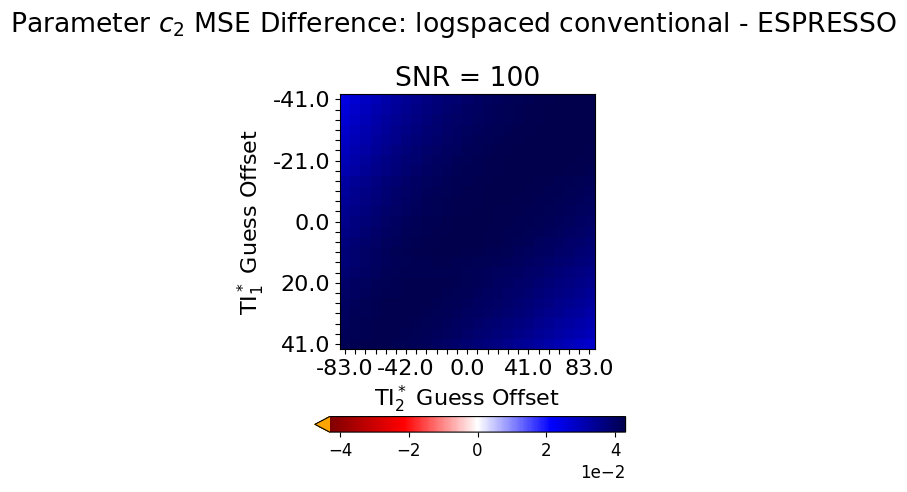

In [23]:
plt.rc('font', size = 16)
fig, ax = plt.subplots(1,1, figsize = (5, 5), tight_layout=True)
fig.suptitle(f"Parameter {ParamTitle_6p[param_oi]} MSE Difference: logspaced conventional - ESPRESSO")


SNR_index = np.where(SNR_input == SR_SNR_values)[0][0]

temp_SR_MSE = SR_MSE[SNR_index,2,param_oi]

print(temp_SR_MSE)
print(MSE.shape)

temp_MSE_imp = temp_SR_MSE-MSE[:,:,0]

gen_patchwork_panel(fig, ax, SNR_input, temp_MSE_imp)

# ax_MSE[1,2].remove()


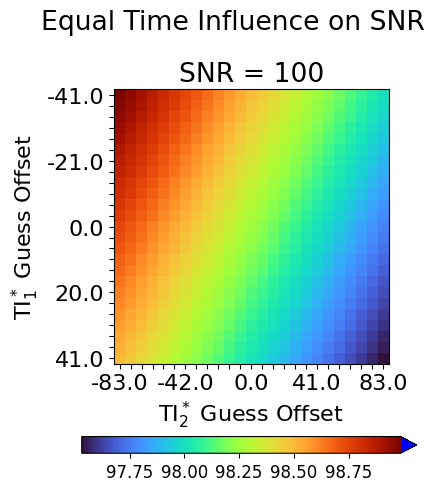

In [24]:
mat_oi = SNRs

eqT_map = plt.get_cmap('turbo')
eqT_map.set_extremes(over = 'blue')
extend_opt = "max"      #max or none

plt.rc('font', size = 16)
fig, ax = plt.subplots(1,1, figsize = (5, 5), tight_layout=True)
fig.suptitle(f"Equal Time Influence on SNR")

plt.rc('font', size = 16)
ax.set_title(f"SNR = {SNR_value}")
imc1 = ax.imshow(mat_oi, cmap = eqT_map)

# ax.set_title('Improvement in ' + param_name_list[POI] + ' MSE')
ax.set_xticks(np.arange(len(np2_array)))
ax.set_yticks(np.arange(len(np1_array)))

temp_x_labels = ["" for a in np2_array]
x_array = [0,len(np2_array)//4,len(np2_array)//2, 3*len(np2_array)//4, -1]
for elem in x_array:
    temp_x_labels[elem] = f"{np2_array[elem]:0.1f}"
ax.set_xticklabels(temp_x_labels)

temp_y_labels = ["" for a in np1_array]
y_array = [0,len(np1_array)//4,len(np1_array)//2, 3*len(np1_array)//4, -1]
for elem in y_array:
    temp_y_labels[elem] = f"{np1_array[elem]:0.1f}"
ax.set_yticklabels(temp_y_labels)

ax.set_ylabel(r'TI$_1^*$ Guess Offset')
ax.set_xlabel(r'TI$_2^*$ Guess Offset')
plt.rc('font', size = 12)
cbar = fig.colorbar(imc1, ax=ax, fraction=0.046, pad=0.2, location = 'bottom', extend = extend_opt)#, format = '%.2e')
# cbar.formatter.set_powerlimits((0,0))

# Example Pixel Histograms

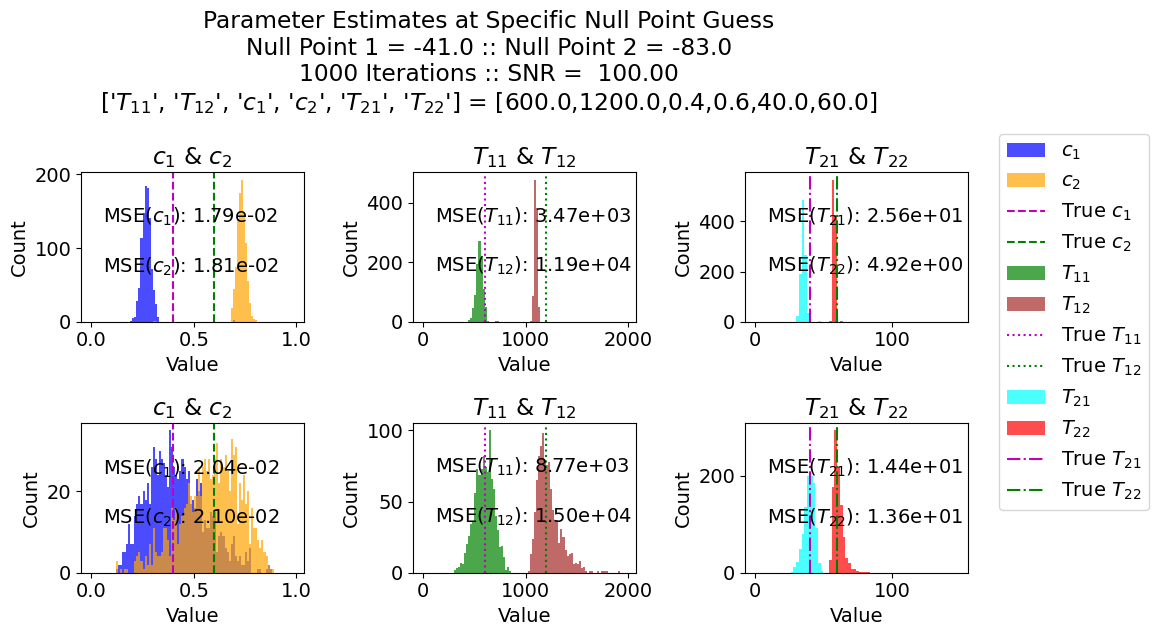

In [26]:
center1_ioi = 0
center2_ioi = 0


plt.rc('font', size = 14)

fig, ax = plt.subplots(2, 3, figsize=(10, 6.5), tight_layout=True)
fig.suptitle(f"Parameter Estimates at Specific Null Point Guess\nNull Point 1 = {np1_array[center1_ioi]} :: Null Point 2 = {np2_array[center2_ioi]}\n{var_reps} Iterations :: SNR = {SNR_input : 0.2f}\n{ParamTitle_6p} = [{T11},{T12},{c1},{c2},{T21},{T22}]")


MSEMat, varMat, sqBMat = calc_MSE(pEst_AIC[center1_ioi, center2_ioi,:,:], true_params)

bin_array = np.arange(0, 1, 0.01)
ax[0,0].hist(x=pEst_AIC[center1_ioi, center2_ioi,:,-4], bins=bin_array, color='b', alpha = 0.7)
ax[0,0].hist(x=pEst_AIC[center1_ioi, center2_ioi,:,-3], bins=bin_array, color='orange', alpha = 0.7)
ax[0,0].axvline(x = true_params[-4], color='m', ls = '--')
ax[0,0].axvline(x = true_params[-3], color='g', ls = '--')
ax[0,0].set_xlabel('Value')
ax[0,0].set_ylabel('Count')
ax[0,0].set_title(f"{ParamTitle_6p[-4]} & {ParamTitle_6p[-3]}")#\nMSE({ParamTitle_6p[-4]}) = {MSEMat[-4]:.2e}\nMSE({ParamTitle_6p[-3]}) = {MSEMat[-3]:.2e}")

ymin, ymax = ax[0,0].get_ylim()
xmin, xmax = ax[0,0].get_xlim()
yup = ymin+(ymax-ymin)*2//3
ydn = ymin+(ymax-ymin)*1//3
ax[0,0].text(xmin+(xmax-xmin)*0.1, yup, f"MSE({ParamTitle_6p[-4]}): {MSEMat[-4] :0.2e}", color = 'k')
ax[0,0].text(xmin+(xmax-xmin)*0.1, ydn, f"MSE({ParamTitle_6p[-3]}): {MSEMat[-3] :0.2e}", color = 'k')

bin_array = np.arange(0, 2000, 20)
ax[0,1].hist(x=pEst_AIC[center1_ioi, center2_ioi,:,0], bins=bin_array, color='g', alpha = 0.7)
ax[0,1].hist(x=pEst_AIC[center1_ioi, center2_ioi,:,1], bins=bin_array, color='brown', alpha = 0.7)
ax[0,1].axvline(x = true_params[0], color='m', ls = ':')
ax[0,1].axvline(x = true_params[1], color='g', ls = ':')
ax[0,1].set_xlabel('Value')
ax[0,1].set_ylabel('Count')
ax[0,1].set_title(f"{ParamTitle_6p[0]} & {ParamTitle_6p[1]}")#\nMSE({ParamTitle_6p[0]}) = {MSEMat[0]:.2e}\nMSE({ParamTitle_6p[1]}) = {MSEMat[1]:.2e}")

ymin, ymax = ax[0,1].get_ylim()
xmin, xmax = ax[0,1].get_xlim()
yup = ymin+(ymax-ymin)*2//3
ydn = ymin+(ymax-ymin)*1//3
ax[0,1].text(xmin+(xmax-xmin)*0.1, yup, f"MSE({ParamTitle_6p[0]}): {MSEMat[0] :0.2e}", color = 'k')
ax[0,1].text(xmin+(xmax-xmin)*0.1, ydn, f"MSE({ParamTitle_6p[1]}): {MSEMat[1] :0.2e}", color = 'k')

bin_array = np.arange(0, 150, 2)
ax[0,2].hist(x=pEst_AIC[center1_ioi, center2_ioi,:,-2], bins=bin_array, color='cyan', alpha = 0.7)
ax[0,2].hist(x=pEst_AIC[center1_ioi, center2_ioi,:,-1], bins=bin_array, color='red', alpha = 0.7)
ax[0,2].axvline(x = true_params[-2], color='m', ls = '-.')
ax[0,2].axvline(x = true_params[-1], color='g', ls = '-.')
ax[0,2].set_xlabel('Value')
ax[0,2].set_ylabel('Count')
ax[0,2].set_title(f"{ParamTitle_6p[-2]} & {ParamTitle_6p[-1]}")#\nMSE({ParamTitle_6p[-2]}) = {MSEMat[-2]:.2e}\nMSE({ParamTitle_6p[-1]}) = {MSEMat[-1]:.2e}")

xmin, xmax = ax[0,2].get_xlim()
ymin, ymax = ax[0,2].get_ylim()
yup = ymin+(ymax-ymin)*2//3
ydn = ymin+(ymax-ymin)*1//3
ax[0,2].text(xmin+(xmax-xmin)*0.1, yup, f"MSE({ParamTitle_6p[-2]}): {MSEMat[-2] :0.2e}", color = 'k')
ax[0,2].text(xmin+(xmax-xmin)*0.1, ydn, f"MSE({ParamTitle_6p[-1]}): {MSEMat[-1] :0.2e}", color = 'k')


MSEMat, varMat, sqBMat = calc_MSE(pEst_cf[center1_ioi, center2_ioi,:,:], true_params)

bin_array = np.arange(0, 1, 0.01)
ax[1,0].hist(x=pEst_cf[center1_ioi, center2_ioi,:,-4], bins=bin_array, color='b', label = r'$c_{1}$', alpha = 0.7)
ax[1,0].hist(x=pEst_cf[center1_ioi, center2_ioi,:,-3], bins=bin_array, color='orange', label = r'$c_{2}$', alpha = 0.7)
ax[1,0].axvline(x = true_params[-4], label = r'True $c_{1}$', color='m', ls = '--')
ax[1,0].axvline(x = true_params[-3], label = r'True $c_{2}$', color='g', ls = '--')
ax[1,0].set_xlabel('Value')
ax[1,0].set_ylabel('Count')
ax[1,0].set_title(f"{ParamTitle_6p[-4]} & {ParamTitle_6p[-3]}")#\nMSE({ParamTitle_6p[-4]}) = {MSEMat[-4]:.2e}\nMSE({ParamTitle_6p[-3]}) = {MSEMat[-3]:.2e}")

xmin, xmax = ax[1,0].get_xlim()
ymin, ymax = ax[1,0].get_ylim()
yup = ymin+(ymax-ymin)*2//3
ydn = ymin+(ymax-ymin)*1//3
ax[1,0].text(xmin+(xmax-xmin)*0.1, yup, f"MSE({ParamTitle_6p[-4]}): {MSEMat[-4] :0.2e}", color = 'k')
ax[1,0].text(xmin+(xmax-xmin)*0.1, ydn, f"MSE({ParamTitle_6p[-3]}): {MSEMat[-3] :0.2e}", color = 'k')

bin_array = np.arange(0, 2000, 20)
ax[1,1].hist(x=pEst_cf[center1_ioi, center2_ioi,:,0], bins=bin_array, color='g', label = r'$T_{11}$', alpha = 0.7)
ax[1,1].hist(x=pEst_cf[center1_ioi, center2_ioi,:,1], bins=bin_array, color='brown', label = r'$T_{12}$', alpha = 0.7)
ax[1,1].axvline(x = true_params[0], label = r'True $T_{11}$', color='m', ls = ':')
ax[1,1].axvline(x = true_params[1], label = r'True $T_{12}$', color='g', ls = ':')
ax[1,1].set_xlabel('Value')
ax[1,1].set_ylabel('Count')
ax[1,1].set_title(f"{ParamTitle_6p[0]} & {ParamTitle_6p[1]}")#\nMSE({ParamTitle_6p[0]}) = {MSEMat[0]:.2e}\nMSE({ParamTitle_6p[1]}) = {MSEMat[1]:.2e}")

xmin, xmax = ax[1,1].get_xlim()
ymin, ymax = ax[1,1].get_ylim()
yup = ymin+(ymax-ymin)*2//3
ydn = ymin+(ymax-ymin)*1//3
ax[1,1].text(xmin+(xmax-xmin)*0.1, yup, f"MSE({ParamTitle_6p[0]}): {MSEMat[0] :0.2e}", color = 'k')
ax[1,1].text(xmin+(xmax-xmin)*0.1, ydn, f"MSE({ParamTitle_6p[1]}): {MSEMat[1] :0.2e}", color = 'k')

bin_array = np.arange(0, 150, 2)
ax[1,2].hist(x=pEst_cf[center1_ioi, center2_ioi,:,-2], bins=bin_array, color='cyan', label = r'$T_{21}$', alpha = 0.7)
ax[1,2].hist(x=pEst_cf[center1_ioi, center2_ioi,:,-1], bins=bin_array, color='red', label = r'$T_{22}$', alpha = 0.7)
ax[1,2].axvline(x = true_params[-2], label = r'True $T_{21}$', color='m', ls = '-.')
ax[1,2].axvline(x = true_params[-1], label = r'True $T_{22}$', color='g', ls = '-.')
ax[1,2].set_xlabel('Value')
ax[1,2].set_ylabel('Count')
ax[1,2].set_title(f"{ParamTitle_6p[-2]} & {ParamTitle_6p[-1]}")#\nMSE({ParamTitle_6p[-2]}) = {MSEMat[-2]:.2e}\nMSE({ParamTitle_6p[-1]}) = {MSEMat[-1]:.2e}")

xmin, xmax = ax[1,2].get_xlim()
ymin, ymax = ax[1,2].get_ylim()
yup = ymin+(ymax-ymin)*2//3
ydn = ymin+(ymax-ymin)*1//3
ax[1,2].text(xmin+(xmax-xmin)*0.1, yup, f"MSE({ParamTitle_6p[-2]}): {MSEMat[-2] :0.2e}", color = 'k')
ax[1,2].text(xmin+(xmax-xmin)*0.1, ydn, f"MSE({ParamTitle_6p[-1]}): {MSEMat[-1] :0.2e}", color = 'k')

fig.legend(loc='center left', bbox_to_anchor=(1, 0.5))